In [8]:
# imports 
import os
import json
import operator
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import random

# settings
BotHash = "BEEB1E1549DDD01226DC2FC912ABAE49"
BotName = "PokerShark2"
SB = 10

# players
Players = ['PokerShark1']

# helper functions
def prettyPrint(*arguments):
    out = ''
    for arg in arguments:
        space = (30-len(arg)) * " "
        out += arg + space
    print(out)

# gets an array of paths to player games
def getGamesPath(playerName):
    return [os.path.join(playerName,f) for f in os.listdir(playerName) if not f.startswith('.')]

# Load game as json object.
def loadGame(path):
    with open(path) as f:
        g = json.load(f)
        # Throw if game not logged by the current version of the bot
        if g["BotHash"] != BotHash:
            #raise Exception("BotHash does not match: " + g["BotHash"])
            pass
        return g

# game statistics
def getGamesCount(playerName):
    # returns number of games played against the given player.
    return len(getGamesPath(playerName))

def getGameResultForPlayer(game, playerName):
    # returns game result for given player.
    results = game["Results"]
    maxStack = 0
    hasMax = []
    # find max stack
    for result in results:
        if maxStack < result["Stack"]:
            maxStack = result["Stack"]
            hasMax= [result["Player"]["Name"]]
        elif maxStack == result["Stack"]:
            hasMax.append(result["Player"]["Name"])
    # find player result
    if playerName in hasMax:
        if len(hasMax) > 1:
            return 'D'
        else:
            return 'W'
    return 'L'

def getWonGamesCount(playerName):
    # returns number of games won against the given player.
    count = 0
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        result = getGameResultForPlayer(game, BotName)
        if result == 'W':
            count += 1
    return count

def getDrewGamesCount(playerName):
    # return number of games drew against the given player.
    count = 0
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        result = getGameResultForPlayer(game, BotName)
        if result == 'D':
            count += 1
    return count

def getLostGamesCount(playerName):
    # return number of games lost against the given player.
    count = 0
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        result = getGameResultForPlayer(game, BotName)
        if result == 'L':
            count += 1
    return count

def getEndStack(playerName):
    # return sum of the stack after the games.
    s = 0
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        for result in game["Results"]:
            if result["Player"]["Name"] == BotName:
                s += result["Stack"]
    return s
            
# round statistics
def getRoundsCount(playerName):
    # returns number of rounds played against the given player.
    count = 0
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        count += len(game["Rounds"])
    return count

def GetRoundResultForPlayer(r, playerName):
    results = r["Winner"]
    winners = len(results)
    won = False
    for result in results:
        if playerName == result["Name"]:
            won = True
            break
    if won:
        if winners > 1:
            return 'D'
        else:
            return 'W'
    return 'L'

def getWonRoundsCount(playerName):
    # returns number of rounds won against the given player.
    count = 0
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        for r in game["Rounds"]:
            result = GetRoundResultForPlayer(r, BotName)
            if result == 'W':
                count += 1
    return count

def getDrewRoundsCount(playerName):
    # return number of games rounds against the given player.
    count = 0
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        for r in game["Rounds"]:
            result = GetRoundResultForPlayer(r, BotName)
            if result == 'D':
                count += 1
    return count

def getLostRoundsCount(playerName):
    # return number of rounds lost against the given player.
    count = 0
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        for r in game["Rounds"]:
            result = GetRoundResultForPlayer(r, BotName)
            if result == 'L':
                count += 1
    return count

def endedBeforeShowdown(r):
    # returns true if one of the two players folded.
    for action in r["History"]:
        if action["Type"] == "Fold":
            return True
    return False

def botFolded(r):
    # returns true if one of the two players folded.
    for action in r["History"]:
        if action["Type"] == "Fold" and action["PlayerName"] == BotName:
            return True
    return False

def getPaid(r,playerName):
    # returns amount paid by player
    amount = 0
    # blinds
    sbp = r['SmallBlindPosition']
    for p in range(len(r['Players'])):
        if r['Players'][p]['Name'] == playerName:
            if p == sbp:
                amount += SB
            else:
                amount += SB + SB
    # calls and raises
    for action in r["History"]:
        if action["Type"] != "Fold" and action["PlayerName"] == playerName:
            amount += action["Amount"]
    return amount

# winning statistics
def getNonShowdownWinningsLine(playerName):
    # line goes down each time bot fold, and up each time your opponent fold.
    x = [0]
    y = [0]
    line = 0
    count = 1
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        for r in game["Rounds"]:
            if endedBeforeShowdown(r):
                if botFolded(r):
                    line -= getPaid(r,BotName)
                else:
                    line += getPaid(r,playerName)
            x.append(count)
            y.append(line)
            count += 1
    return (x,y)

def getShowdownWinningsLine(playerName):
    # line goes down each time bot fold, and up each time your opponent fold.
    x = [0]
    y = [0]
    line = 0
    count = 1
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        for r in game["Rounds"]:
            if not endedBeforeShowdown(r):
                # if bot won
                if GetRoundResultForPlayer(r, BotName) == 'W':
                    line += getPaid(r,playerName)
                if GetRoundResultForPlayer(r, BotName) == 'L':
                    line -= getPaid(r,BotName)
                
            x.append(count)
            y.append(line)
            count += 1
    return (x,y)

def getStackLine(playerName):
    # line goes down each time bot fold, and up each time your opponent fold.
    x = [0]
    y = [0]
    line = 0
    count = 1
    files = getGamesPath(playerName)
    for file in files:
        game = loadGame(file)
        for r in game["Rounds"]:
            if GetRoundResultForPlayer(r, BotName) == 'W':
                line += getPaid(r,playerName)
            if GetRoundResultForPlayer(r, BotName) == 'L':
                line -= getPaid(r,BotName)
            x.append(count)
            y.append(line)
            count += 1
    return (x,y)

def plotWinnings(playerName):
    # NonShowdownWinningsLine
    x,y = getNonShowdownWinningsLine(playerName)
    fig, ax = plt.subplots()
    xpoints = np.array(x)
    ypoints = np.array(y)
    ax.plot(xpoints, ypoints,linewidth=1,label='Non-showdown winnings', c='r')
    # ShowdownWinningsLine
    x,y = getShowdownWinningsLine(playerName)
    xpoints = np.array(x)
    ypoints = np.array(y)
    ax.plot(xpoints, ypoints,linewidth=1,label='Showdown winnings', c='b')
    # Stack
    x,y = getStackLine(playerName)
    xpoints = np.array(x)
    ypoints = np.array(y)
    ax.plot(xpoints, ypoints,linewidth=1,label='Winnings', c='g')
    # show plot
    y_max = np.abs(ax.get_ylim()).max()
    ax.set_ylim(ymin=-y_max, ymax=y_max)
    ax.set_xlim(left=0)
    plt.legend()
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.show()
    
    
# Print Results
def PrintResult():
    for player in Players:
        prettyPrint("Results against:", player)
        # game statistics
        n = getGamesCount(player)
        w = getWonGamesCount(player)
        d = getDrewGamesCount(player)
        l = getLostGamesCount(player)
        prettyPrint("number of games:",str(n))
        prettyPrint("number of games won:", str(w) , "{:.1f}".format(w*100/n) + "%")
        prettyPrint("number of games drew:", str(d), "{:.1f}".format(d*100/n) + "%")
        prettyPrint("number of games lost:", str(l), "{:.1f}".format(l*100/n) + "%")
        # round statistics
        rn = getRoundsCount(player)
        rw = getWonRoundsCount(player)
        rd = getDrewRoundsCount(player)
        rl = getLostRoundsCount(player)
        prettyPrint("number of rounds:",str(rn))
        prettyPrint("number of rounds won:", str(rw) , "{:.1f}".format(rw*100/rn) + "%")
        prettyPrint("number of rounds drew:", str(rd), "{:.1f}".format(rd*100/rn) + "%")
        prettyPrint("number of rounds lost:", str(rl), "{:.1f}".format(rl*100/rn) + "%")
        # winnings
        prettyPrint("starting stack:", str(1000 * n))
        prettyPrint("end stack:", str(getEndStack(player)))
        prettyPrint("win/loss:", str(getEndStack(player) - (1000 * n)  ))
        prettyPrint("WPH:", str((getEndStack(player) - (1000 * n)) / (rn*10)))
        plotWinnings(player)
        # end
        print('-------------------------------------------------------------')
        
      

Dynamic player:
Results against:              PokerShark2                   
number of games:              100                           
number of games won:          10                            10.0%                         
number of games drew:         0                             0.0%                          
number of games lost:         90                            90.0%                         
number of rounds:             9906                          
number of rounds won:         3545                          35.8%                         
number of rounds drew:        7                             0.1%                          
number of rounds lost:        6354                          64.1%                         
starting stack:               100000                        
end stack:                    67070.0                       
win/loss:                     -32930.0                      
WPH:                          -0.33242479305471434          


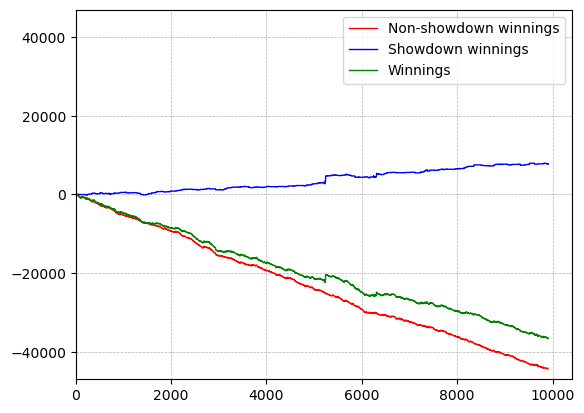

-------------------------------------------------------------
risk-seeking player:
Results against:              PokerShark1                   
number of games:              100                           
number of games won:          90                            90.0%                         
number of games drew:         0                             0.0%                          
number of games lost:         10                            10.0%                         
number of rounds:             9906                          
number of rounds won:         6354                          64.1%                         
number of rounds drew:        7                             0.1%                          
number of rounds lost:        3545                          35.8%                         
starting stack:               100000                        
end stack:                    132930.0                      
win/loss:                     32930.0                       
WPH: 

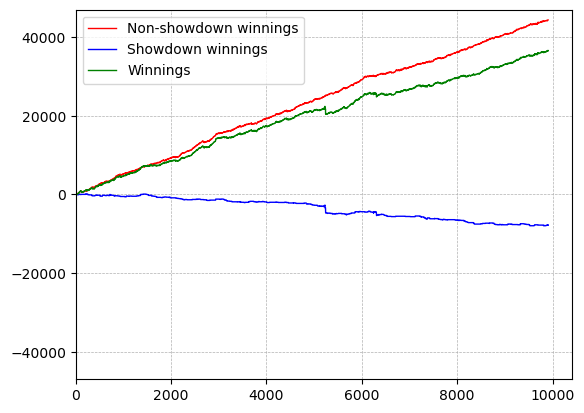

-------------------------------------------------------------


In [9]:
import os

dynamic = "PokerShark1"
seeking = "PokerShark2"

# print Dynamic stats
print("Dynamic player:")
BotName = dynamic
os.rename("games", seeking)
Players = [seeking]
PrintResult()

# print Risk seeking stats
print("risk-seeking player:")
BotName = seeking
os.rename(seeking, dynamic)
Players = [dynamic]
PrintResult()
os.rename(dynamic, "games")


